#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. We will be analyzing the relationship between *Senators* and *Subjects* they are interested in. This type of social network is known as *affiliation* or *bipartite* networks.

###Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###We will be extracting following information from the data

- Senators presenting most bills
- Subjects on which most bills are presented.

###Data Source

For the project, we are analyzing affiliation between sponsors and subjects of bills within the U.S. Senate of the 114th Congress that met from January 3, 2015, to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject as `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

#Small subset of data
query = ("SELECT senator, `subject`, COUNT(1) AS weight FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`")

smallSubset = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Small subset
subSetsenatorsList = smallSubset.senator.unique()
subSetsubjectList = smallSubset.subject.unique()

subSetsenatorsList = subSetsenatorsList.tolist()
subSetsubjectList = subSetsubjectList.tolist()

###Classification of bills sponsored by Senator based on subject.

In [3]:
#Weight shows number of bills presented on a subject by Senator
subjectInfo.sort_values(['weight'], ascending = False, inplace=True)
subjectInfo

senator                              subject  weight
710        Lisa Murkowski                               Energy      30
887        Orrin G. Hatch                             Taxation      23
204        Chuck Grassley                               Health      21
716        Lisa Murkowski   Public lands and natural resources      17
290          David Vitter                               Health      17
638            Jon Tester   Armed forces and national security      15
107          Bill Cassidy                               Health      15
645            Jon Tester                     Native Americans      14
280          David Vitter                             Commerce      13
1135        Sherrod Brown                               Health      13
859           Mike Rounds   Armed forces and national security      13
1090            Ron Wyden   Public lands and natural resources      13
199        Chuck Grassley            Crime and law enforcement      13
359      Edward J. Markey                               Energy      13
1093            Ron Wyden                             Taxation      12
761      Mark Steven Kirk   Armed forces and national security      12
465        Jeanne Shaheen   Armed forces and national security      12
626            John Thune                             Taxation      12
523           Jerry Moran   Armed forces and national security      11
769      Mark Steven Kirk                               Health      11
562         John Barrasso                     Native Americans      11
151    Charles E. Schumer            Crime and law enforcement      11
1050  Robert P. Jr. Casey                               Health      11
301           Dean Heller   Armed forces and national security      11
83     Benjamin L. Cardin                International affairs      11
1073          Ron Johnson   Government operations and politics      11
5              Al Franken                               Health      11
957    Richard Blumenthal   Armed forces and national security      10
872        Orrin G. Hatch            Crime and law enforcement      10
728           Marco Rubio                International affairs      10
...                   ...                                  ...     ...
623            John Thune                     Native Americans       1
629        Johnny Isakson         Economics and public finance       1
630        Johnny Isakson   Government operations and politics       1
572          John Boozman                               Energy       1
570          John Boozman              Arts, culture, religion       1
568          John Boozman                 Agriculture and food       1
546          Joe Donnelly                 Labor and employment       1
531           Jerry Moran                                  Law       1
533           Jerry Moran   Public lands and natural resources       1
534           Jerry Moran  Science, technology, communications       1
537           Jerry Moran          Water resources development       1
539          Joe Donnelly            Crime and law enforcement       1
540          Joe Donnelly                            Education       1
541          Joe Donnelly             Environmental protection       1
543          Joe Donnelly   Government operations and politics       1
544          Joe Donnelly                               Health       1
545          Joe Donnelly    Housing and community development       1
547          Joe Donnelly      Transportation and public works       1
566         John Barrasso      Transportation and public works       1
548       Joe Manchin III   Armed forces and national security       1
549       Joe Manchin III         Economics and public finance       1
551       Joe Manchin III         Finance and financial sector       1
552       Joe Manchin III   Government operations and politics       1
554       Joe Manchin III                 Labor and employment       1
555       Joe Manchin III   Public lands a

Lisa Murkowski is the Chairman of Committee on Energy and Natural Resources. Orrin G. Hatch is the Chairman of Committee on Finance.

###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a bill subject. Sets of nodes are related, but there is no relation between each set of nodes. This shows there is no connection between Senators. We can also notice there is no link between bill subjects.

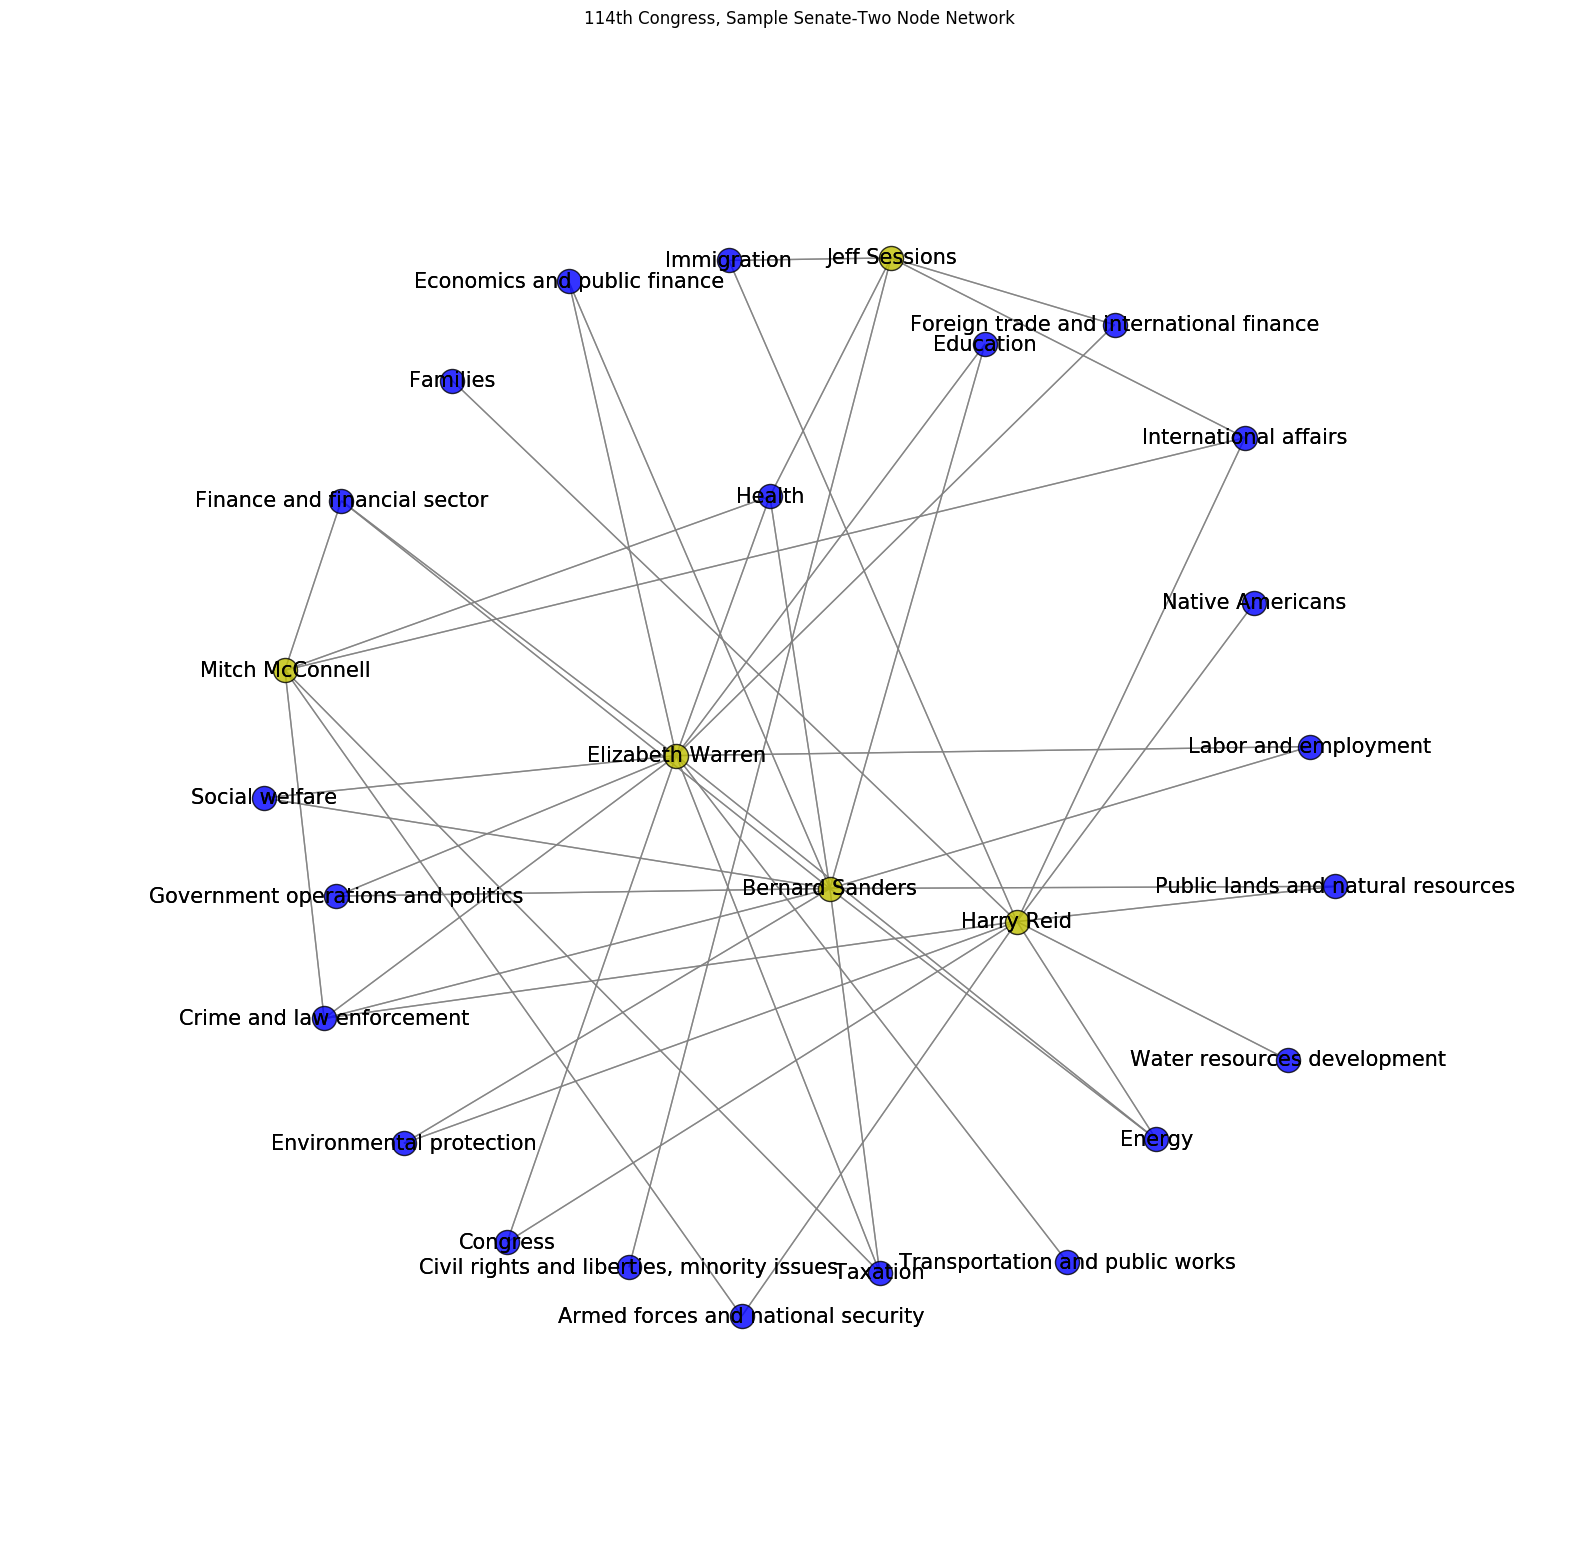

In [4]:
#Small subset data to show two-mode graph
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(subSetsenatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subSetsubjectList, bipartite=1)

for index, row in smallSubset.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.5, iterations=25)
nx.draw(B, nodelist = subSetsenatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subSetsubjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Sample Senate-Two Node Network')
plt.show()

Following is an entire two-mode graph showing a relationship between Senators and bill subjects. We will be working with the whole dataset for the rest of the project.

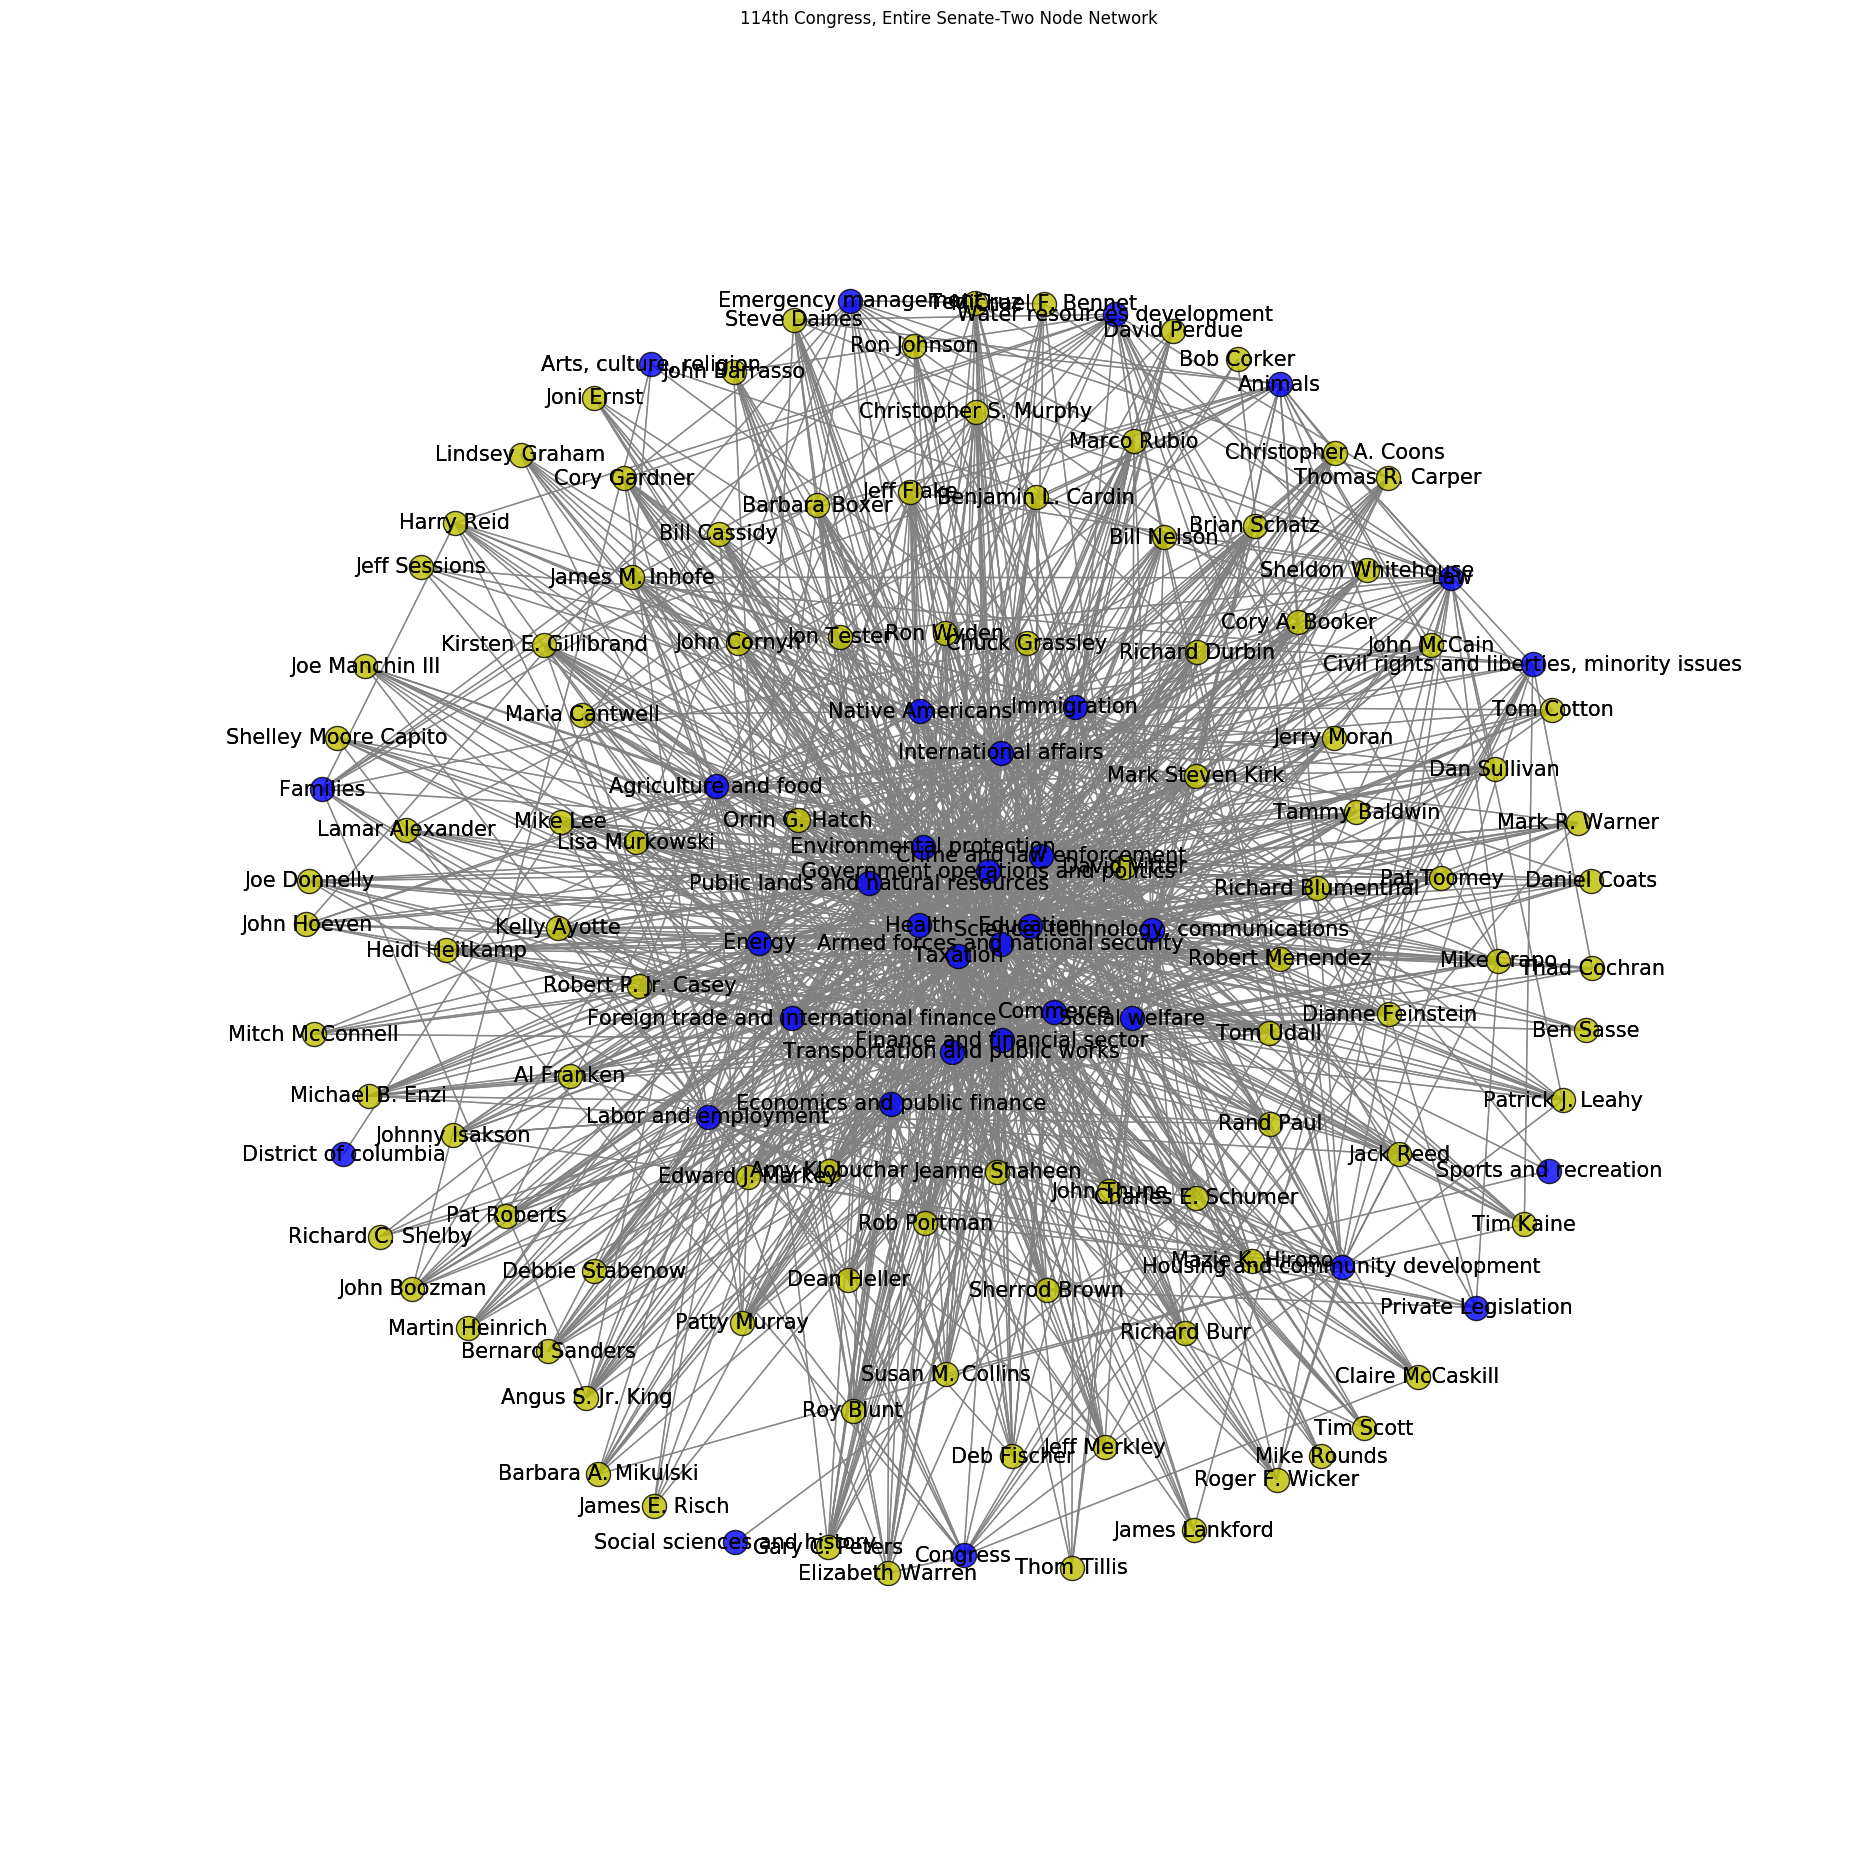

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(18, 18))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'], weight=row['weight'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.spring_layout(B, k=0.3, iterations=75)
nx.draw(B, nodelist = senatorsList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'y', arrows=True)
nx.draw(B, nodelist = subjectList, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b', arrows=True)

plt.title('114th Congress, Entire Senate-Two Node Network')
plt.show()

Get information about node sets. There are 100 Senators and 34 bill subjects.

In [6]:
#Graph can be queried to get information about node sets
top_nodes, bottom_nodes = bipartite.sets(B)

#Total of 100 Senators
print (len(top_nodes))

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Senators'])
df

34


Senators
0                         Sports and recreation
1                                     Education
2                      Environmental protection
3                          Labor and employment
4       Foreign trade and international finance
5                                      Congress
6            Armed forces and national security
7                          Agriculture and food
8                                      Families
9                                        Energy
10                                  Immigration
11                                     Taxation
12                  Social sciences and history
13           Public lands and natural resources
14                 Finance and financial sector
15                                      Animals
16                                       Health
17  Civil rights and liberties, minority issues
18                    Crime and law enforcement
19                          Private Legislation
20                             Native Americans
21                                     Commerce
22                         District of columbia
23              Transportation and public works
24                 Economics and public finance
25          Science, technology, communications
26            Housing and community development
27                        International affairs
28                                          Law
29                               Social welfare
30                  Water resources development
31                         Emergency management
32                      Arts, culture, religion
33           Government operations and politics

In [7]:
#Total of 34 Bill Subjects
print (len(bottom_nodes))

#Bill Subjects
df = pd.DataFrame(list(bottom_nodes), columns=['Subjects'])
df

100


Subjects
0               Rand Paul
1              Jeff Flake
2          Heidi Heitkamp
3        Patrick J. Leahy
4         Debbie Stabenow
5                Mike Lee
6               Roy Blunt
7            Kelly Ayotte
8            Patty Murray
9             John Cornyn
10     Benjamin L. Cardin
11           Dan Sullivan
12     Richard Blumenthal
13  Christopher S. Murphy
14            Rob Portman
15            Jerry Moran
16        Martin Heinrich
17            Bill Nelson
18              Ben Sasse
19       Claire McCaskill
20        Mitch McConnell
21       Edward J. Markey
22             Pat Toomey
23         James E. Risch
24          Sherrod Brown
25             Harry Reid
26    Barbara A. Mikulski
27          Barbara Boxer
28             Bob Corker
29             Tom Cotton
..                    ...
70           Richard Burr
71            John Hoeven
72        Joe Manchin III
73           Bill Cassidy
74             Jon Tester
75        Bernard Sanders
76        Lamar Alexander
77              Ron Wyden
78  Kirsten E. Gillibrand
79              Tim Scott
80             Al Franken
81               Ted Cruz
82       Elizabeth Warren
83       Mark Steven Kirk
84       Susan M. Collins
85            Thom Tillis
86           Thad Cochran
87          John Barrasso
88   Christopher A. Coons
89      Richard C. Shelby
90            Ron Johnson
91          Jeff Sessions
92        Robert Menendez
93             Joni Ernst
94              Tom Udall
95         Richard Durbin
96         Mark R. Warner
97           Jeff Merkley
98         James Lankford
99             Mike Crapo

[100 rows x 1 columns]

In [8]:
#Get total number of nodes in the graph (Senators + Bill Subjects)
bipartite.sets(B)
nx.number_of_nodes(B)

134

In [9]:
#Diameter of the graph. Total number of bill presented by Senators during 114th congress.
print(B.size())

1265


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 1 and bill subject bipartite value is 0
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

Node  bipartite
88                                    Al Franken          0
79                                 Amy Klobuchar          0
3                              Angus S. Jr. King          0
65                           Barbara A. Mikulski          0
66                                 Barbara Boxer          0
20                                     Ben Sasse          0
29                            Benjamin L. Cardin          0
57                               Bernard Sanders          0
24                                  Bill Cassidy          0
43                                   Bill Nelson          0
67                                    Bob Corker          0
120                                 Brian Schatz          0
94                            Charles E. Schumer          0
112                         Christopher A. Coons          0
78                         Christopher S. Murphy          0
105                               Chuck Grassley          0
45                              Claire McCaskill          0
70                                Cory A. Booker          0
92                                  Cory Gardner          0
30                                  Dan Sullivan          0
47                                  Daniel Coats          0
77                                  David Perdue          0
91                                  David Vitter          0
62                                   Dean Heller          0
102                                  Deb Fischer          0
15                               Debbie Stabenow          0
110                             Dianne Feinstein          0
80                              Edward J. Markey          0
96                              Elizabeth Warren          0
109                               Gary C. Peters          0
..                                           ...        ...
32   Civil rights and liberties, minority issues          1
40                                      Commerce          1
19                                      Congress          1
33                     Crime and law enforcement          1
41                          District of columbia          1
50                  Economics and public finance          1
6                                      Education          1
97                          Emergency management          1
90                                        Energy          1
76                      Environmental protection          1
18                                      Families          1
107                 Finance and financial sector          1
14       Foreign trade and international finance          1
131           Government operations and politics          1
106                                       Health          1
52             Housing and community development          1
68                                   Immigration          1
53                         International affairs          1
81                          Labor and employment          1
84                                           Law          1
75                              Native Americans          1
34                           Private Legislation          1
98            Public lands and natural resources          1
51           Science, technology, communications          1
114                  Social sciences and history          1
55                                Social welfare          1
4                          Sports and recreation          1
95                                      Taxation          1
48               Transportation and public works          1
93                   Water resources development          1

[134 rows x 2 columns]

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric shows, bills sponsored by Senator Amy Klobuchar on subjects *Health* and *Science, technology, communications* make it to the floor faster compared to Senator Tom Cotton and Senator Tom Udall.

Example:
Minnesota Democratic Senator Amy Klobuchar has sponsored bills on subjects *Health* and *Science, technology, communications*. She and her staff have more experience than Arkansas Republican Senator Tom Cotton in getting these bills through committees and onto the Senate floor. If people of Arkansas want any legislation introduced related to *Health* and *Science, technology, communications* their chances of getting the bill onto the floor through Senator Amy Klobuchar are very high compared to   Senator Tom Cotton.

In [11]:
#Gives information about average shortest path between Senators and Subjects. 
#Every Senator has at least two subjects common with other Senators.
nx.average_shortest_path_length(B)

2.116934126360678

In [12]:
#Shortest path between Senators and bill subjects
#Value is close to average shortest path.
df = pd.DataFrame(list(bipartite.color(B).items()), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 1)]
df2 = df[(df.bipartite == 0)]

cols = ['Senator', 'Subject', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Senator', 'Subject'], ascending = True, inplace=True)
ShortPath

Senator                Subject  ShortestPath
357          Agriculture and food          Amy Klobuchar             1
303          Agriculture and food      Angus S. Jr. King             1
356          Agriculture and food  Christopher S. Murphy             1
375          Agriculture and food         Chuck Grassley             1
323          Agriculture and food           Dan Sullivan             1
355          Agriculture and food           David Perdue             1
365          Agriculture and food           David Vitter             1
317          Agriculture and food        James M. Inhofe             1
302          Agriculture and food         Jeanne Shaheen             1
304          Agriculture and food             Jeff Flake             1
327          Agriculture and food            Jerry Moran             1
359          Agriculture and food           John Boozman             1
334          Agriculture and food            John Hoeven             1
351          Agriculture and food  Kirsten E. Gillibrand             1
307          Agriculture and food         Lisa Murkowski             1
313          Agriculture and food               Mike Lee             1
364          Agriculture and food            Pat Roberts             1
386          Agriculture and food       Patrick J. Leahy             1
389          Agriculture and food           Patty Murray             1
324          Agriculture and food     Richard Blumenthal             1
390          Agriculture and food         Richard Durbin             1
383          Agriculture and food        Robert Menendez             1
325          Agriculture and food    Robert P. Jr. Casey             1
320          Agriculture and food        Roger F. Wicker             1
381          Agriculture and food            Ron Johnson             1
370          Agriculture and food       Susan M. Collins             1
388          Agriculture and food              Tom Udall             1
622                       Animals     Benjamin L. Cardin             1
618                       Animals           Bill Cassidy             1
680                       Animals   Christopher A. Coons             1
...                           ...                    ...           ...
2610  Water resources development        Michael B. Enzi             3
2619  Water resources development      Michael F. Bennet             3
2613  Water resources development               Mike Lee             3
2684  Water resources development            Mike Rounds             3
2628  Water resources development        Mitch McConnell             3
2611  Water resources development         Orrin G. Hatch             3
2664  Water resources development            Pat Roberts             3
2640  Water resources development             Pat Toomey             3
2686  Water resources development       Patrick J. Leahy             3
2689  Water resources development           Patty Murray             3
2600  Water resources development              Rand Paul             3
2624  Water resources development     Richard Blumenthal             3
2632  Water resources development           Richard Burr             3
2637  Water resources development      Richard C. Shelby             3
2690  Water resources development         Richard Durbin             3
2676  Water resources development            Rob Portman             3
2683  Water resources development        Robert Menendez             3
2625  Water resources development    Robert P. Jr. Casey             3
2620  Water resources development        Roger F. Wicker             3
2681  Water resources development            Ron Johnson             3
2615  Water resources development              Roy Blunt             3
2616  Water resources development   Shelley Moore Capito             3
2642  Water resources development          Sherrod Brown             3
2670  Water resources development       Susan M. Collins             3
2606  Water resources development               Te

###Node centralities

We will be showing metrics

- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, *Health* and *Taxation* top the list in all three metrics. In other words, both subjects unite Senators closely than any other subject. Subject *District of Columbia* least popular among Senators.

In [13]:
#Closeness Betweenness Degrees centrality between Senetors and Subjects
close = nx.closeness_centrality(B)
between = nx.betweenness_centrality(B)
degree = nx.degree_centrality(B)
df1 = pd.DataFrame(list(close.items()), columns=['Node', 'Closeness'])
df2 = pd.DataFrame(list(between.items()), columns=['Node', 'Betweenness'])
df3 = pd.DataFrame(list(degree.items()), columns=['Node', 'Degrees'])
df = df1.join(df2.set_index('Node'), on='Node').join(df3.set_index('Node'), on='Node')
df.sort_values(['Closeness', 'Betweenness','Degrees'], ascending = False, inplace=True)
df

Node  Closeness  Betweenness  \
107                                       Health   0.692708     0.101990   
95                                      Taxation   0.651961     0.081904   
98            Public lands and natural resources   0.604545     0.064795   
131           Government operations and politics   0.599099     0.063533   
87            Armed forces and national security   0.588496     0.064645   
35                     Crime and law enforcement   0.545082     0.045923   
50               Transportation and public works   0.545082     0.042655   
5                                      Education   0.527778     0.035685   
7                                   David Vitter   0.523622     0.008982   
85                         International affairs   0.519531     0.046628   
108                 Finance and financial sector   0.515504     0.036473   
78                      Environmental protection   0.515504     0.033388   
80                                 Amy Klobuchar   0.515504     0.006491   
4                                     Jeff Flake   0.511538     0.006419   
2                                 Jeanne Shaheen   0.507634     0.006398   
14                                Orrin G. Hatch   0.507634     0.005318   
94                            Charles E. Schumer   0.503788     0.021357   
17                                      Mike Lee   0.503788     0.019391   
121                                    Tom Udall   0.503788     0.009767   
30                            Richard Blumenthal   0.503788     0.009606   
116                              Robert Menendez   0.503788     0.006964   
67                                     Ron Wyden   0.503788     0.005168   
32                                Richard Durbin   0.503788     0.004653   
109                                  Rob Portman   0.503788     0.004406   
124                             Mark Steven Kirk   0.503788     0.004089   
47                               James M. Inhofe   0.500000     0.008501   
44                                   Bill Nelson   0.500000     0.007933   
133                                   Mike Crapo   0.500000     0.006094   
111                             Dianne Feinstein   0.500000     0.005646   
40                                   Marco Rubio   0.500000     0.004304   
..                                           ...        ...          ...   
64                               Lamar Alexander   0.458621     0.000788   
22                          Shelley Moore Capito   0.458621     0.000670   
104                                 Thad Cochran   0.458621     0.000557   
39                               Mitch McConnell   0.458621     0.000255   
72                                 Jeff Sessions   0.449324     0.000474   
46                                     Ben Sasse   0.449324     0.000134   
52                  Economics and public finance   0.446309     0.015759   
84                                   Mike Rounds   0.446309     0.000284   
114                            Richard C. Shelby   0.446309     0.000151   
23                                   Immigration   0.443333     0.015822   
56                                Social welfare   0.443333     0.014690   
15       Foreign trade and international finance   0.437500     0.015152   
101                                  Thom Tillis   0.437500     0.000262   
122                               James E. Risch   0.437500     0.000176   
18                          Agriculture and food   0.423567     0.008114   
41                              Native Americans   0.420886     0.008903   
55                                           Law   0.418239     0.006880   
31             Housing and community development   0.413043     0.007747   
126                  Water resources development   0.407975     0.004550   
26                                       Animals   0.398204     0.003565   
86                                      Congress   0.393491     0.002552   
99   Civil right

###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

Following is the projected graph of Senators.

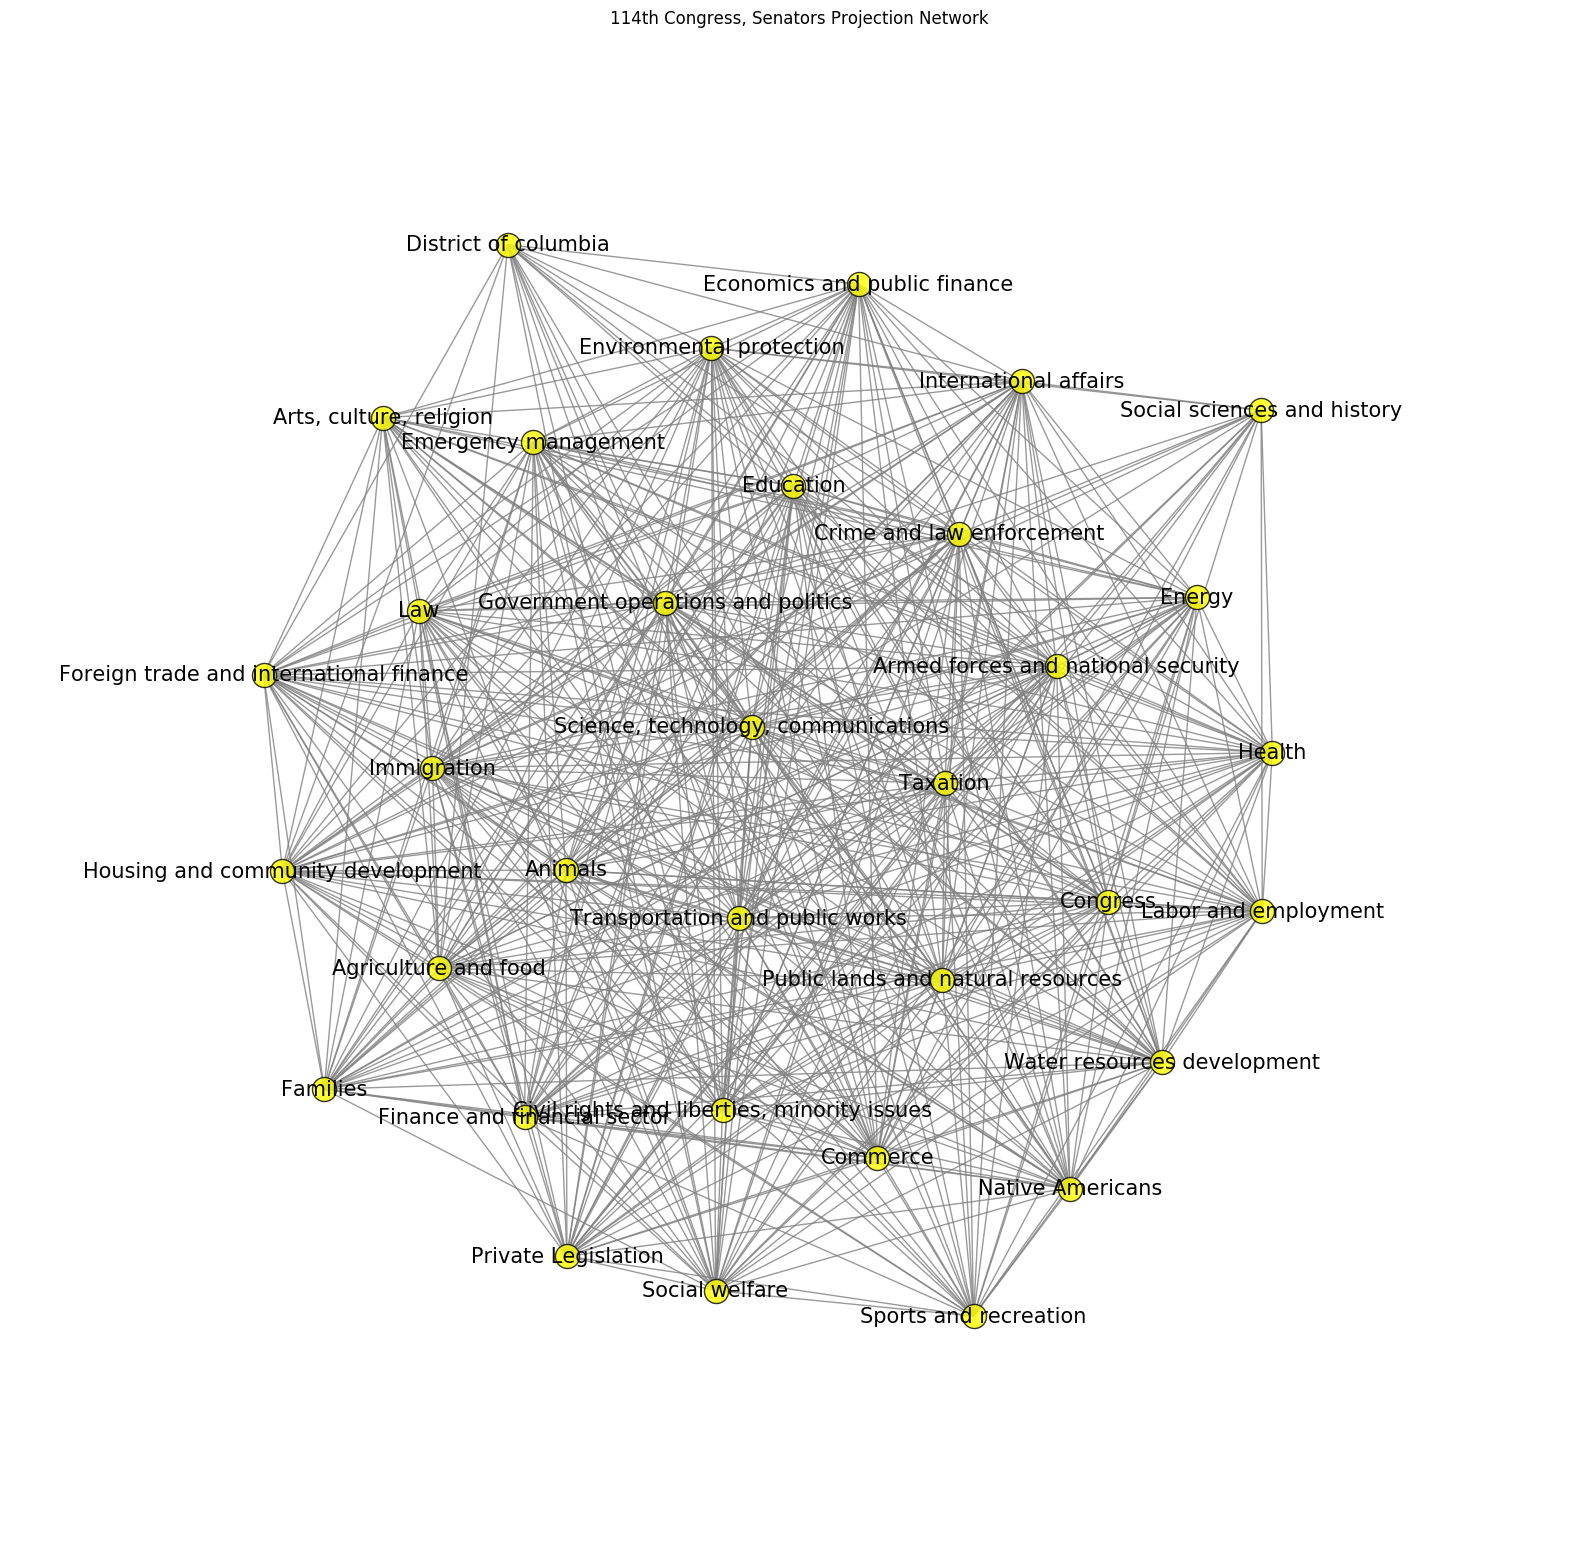

In [14]:
#Graph shows Senators are tightly connected.
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.6, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'yellow')
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of bill subjects. 

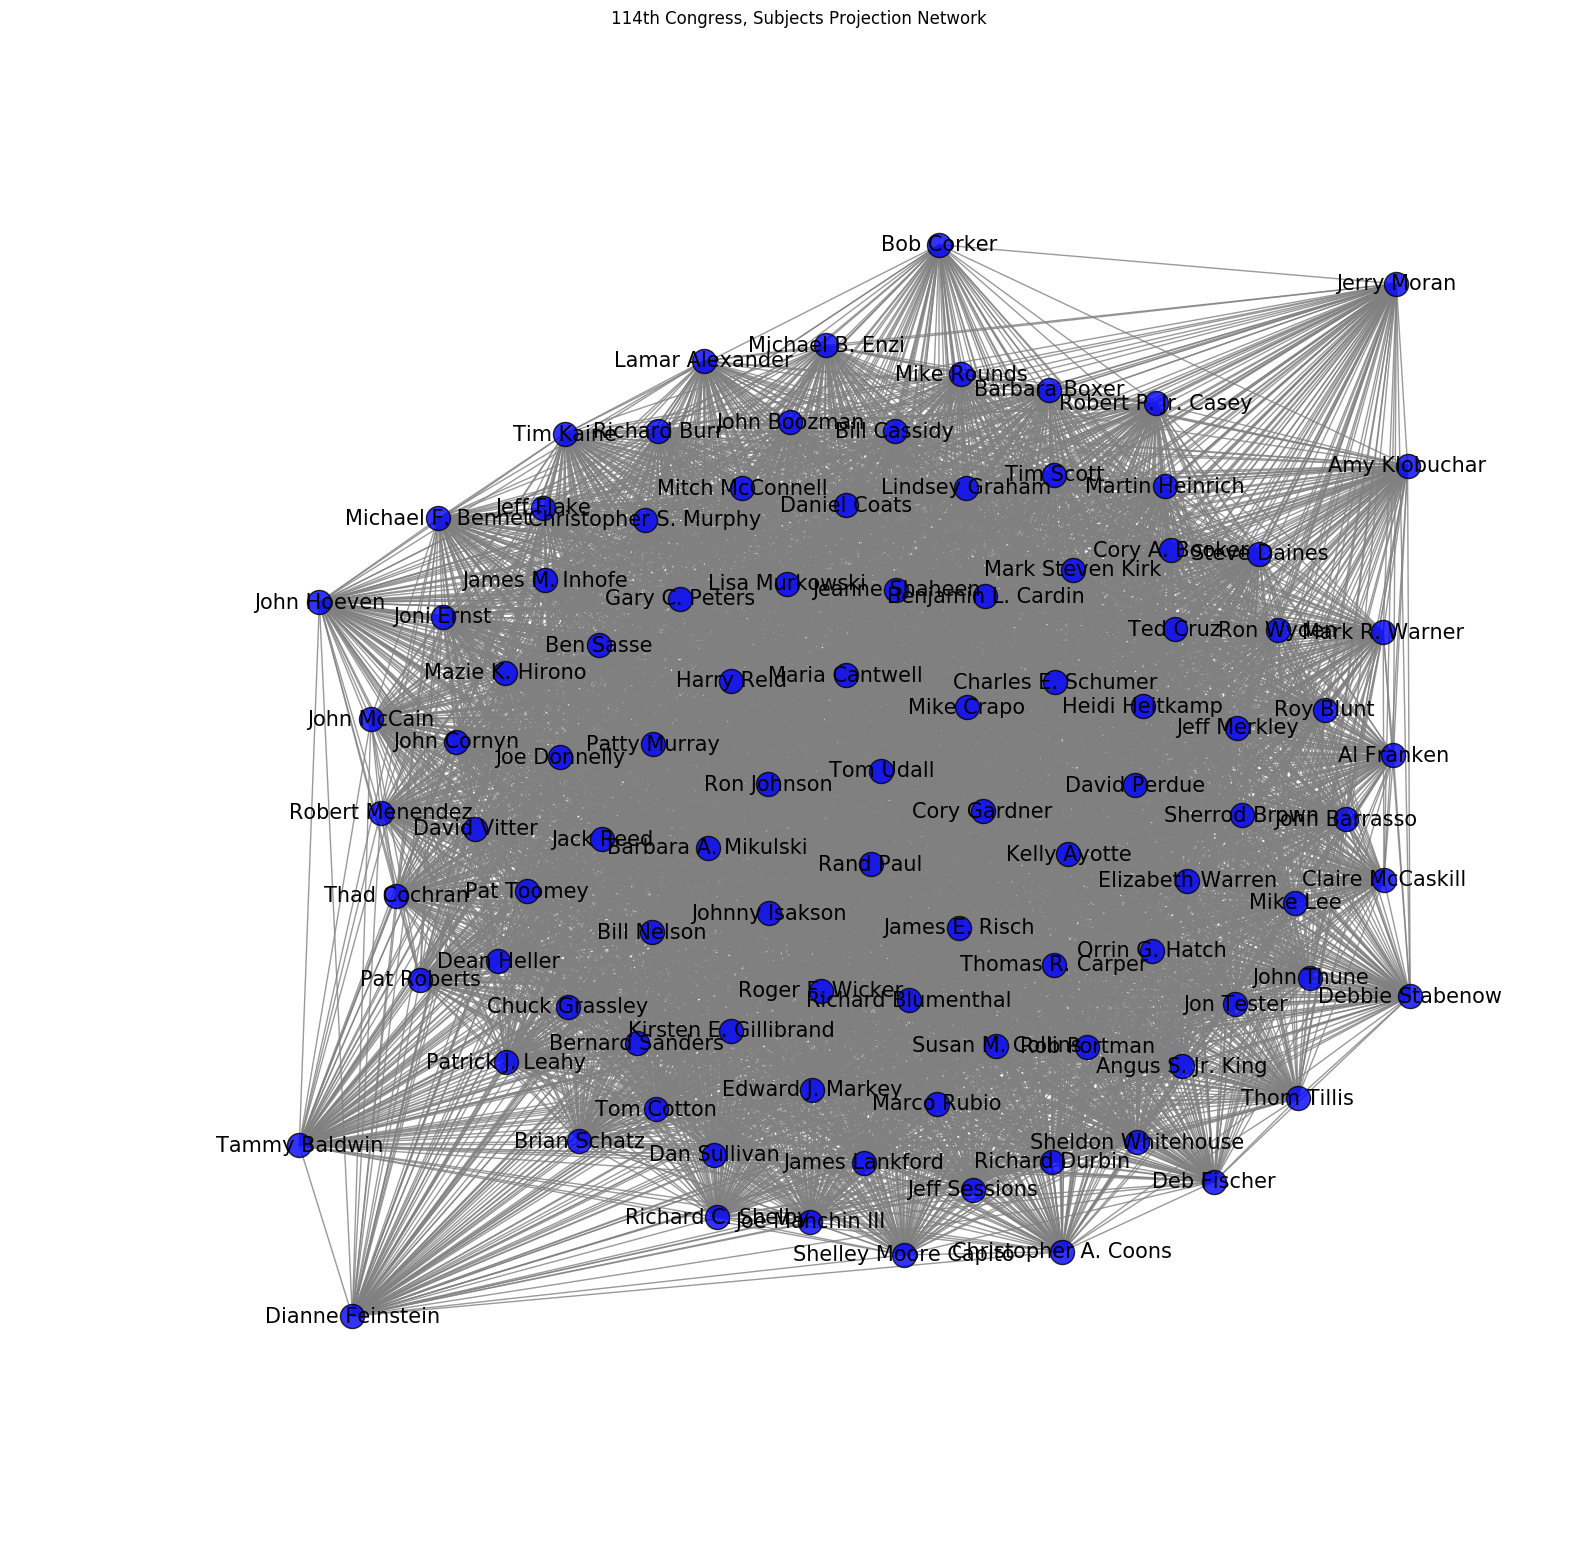

In [15]:
#Graph shows they are connected to the most part.
#Not all subjects are linked. Example: Social sciences & history and District of Columbia
#They were least popular among Senators

G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=25)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8, edge_color = 'grey', node_color = 'b')
plt.title('114th Congress, Subjects Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are evenly dense. Output suggests it is not a dense graph.

In [16]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))

0.3720588235294118
0.3720588235294118


###Clustering

Two-mode clustering metrics show there is a high level of clustering around Senators Gary C. Peters, Senator Edward J. Markey and Senator Amy Klobuchar. In other words Senators are creating clusters around subjects. We can assume that Senators are more actively working on subjects.

In [17]:
c = bipartite.clustering(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

Node  Clustering
110                               Gary C. Peters    0.467979
81                              Edward J. Markey    0.466050
80                                 Amy Klobuchar    0.465132
109                                  Rob Portman    0.458394
124                             Mark Steven Kirk    0.457735
34                                  Patty Murray    0.449602
129                                Tammy Baldwin    0.443799
49                                  Brian Schatz    0.443223
14                                Orrin G. Hatch    0.438549
21                                     Roy Blunt    0.433688
69                                 Barbara Boxer    0.429799
115                                  Dean Heller    0.428701
67                                     Ron Wyden    0.428436
62                                  Kelly Ayotte    0.427624
32                                Richard Durbin    0.424544
74                         Kirsten E. Gillibrand    0.424226
27                                   John Cornyn    0.423339
7                                   David Vitter    0.422189
2                                 Jeanne Shaheen    0.421120
13                               Michael B. Enzi    0.416889
54                                  Bill Cassidy    0.415656
92                                  Cory Gardner    0.414451
38                                   Jerry Moran    0.406920
73                                Cory A. Booker    0.406413
8                                     John Thune    0.406024
59                               Bernard Sanders    0.404171
40                                   Marco Rubio    0.402996
79                         Christopher S. Murphy    0.402861
117                           Sheldon Whitehouse    0.398786
4                                     Jeff Flake    0.398304
..                                           ...         ...
132                               James Lankford    0.248444
66                                    Harry Reid    0.244810
93                                  David Perdue    0.236183
104                                 Thad Cochran    0.228641
52                  Economics and public finance    0.218295
56                                Social welfare    0.214168
23                                   Immigration    0.211763
55                                           Law    0.207037
18                          Agriculture and food    0.205080
122                               James E. Risch    0.201195
15       Foreign trade and international finance    0.200920
84                                   Mike Rounds    0.189306
46                                     Ben Sasse    0.185288
41                              Native Americans    0.174577
126                  Water resources development    0.169541
31             Housing and community development    0.167055
101                                  Thom Tillis    0.165161
114                            Richard C. Shelby    0.164930
72                                 Jeff Sessions    0.153204
26                                       Animals    0.148732
75                          Emergency management    0.145375
99   Civil rights and liberties, minority issues    0.126924
86                                      Congress    0.118515
19                                      Families    0.118401
70                                    Bob Corker    0.101726
36                           Private Legislation    0.082698
60                       Arts, culture, religion    0.053245
77                         Sports and recreation    0.042717
97                   Social sciences and history    0.032616
42                          District of columbia    0.025329

[134 rows x 2 columns]

###Local clustering coefficient for two-mode networks

Clustering values obtained using *Robins Alexander method* and *Global Average Method* differ because *Robins Alexander method* clustering coefficients for two-mode networks are based on 4-cycles, which is the smallest possible cycle in two-mode networks. Robins and Alexander defined a coefficient as the ratio between the number of 4-cycles and the number of 3-paths.

Whereas *Global Average Method* uses one-mode clustering coefficient to detect closure among three nodes. Hence the difference in values.

Reference: https://toreopsahl.com/tnet/two-mode-networks/clustering/

In [18]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.552
0.316


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [19]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1  \
0      Civil rights and liberties, minority issues   
1      Civil rights and liberties, minority issues   
2      Civil rights and liberties, minority issues   
3      Civil rights and liberties, minority issues   
4      Civil rights and liberties, minority issues   
5      Civil rights and liberties, minority issues   
6      Civil rights and liberties, minority issues   
7      Civil rights and liberties, minority issues   
8      Civil rights and liberties, minority issues   
9      Civil rights and liberties, minority issues   
10     Civil rights and liberties, minority issues   
11     Civil rights and liberties, minority issues   
12     Civil rights and liberties, minority issues   
13     Civil rights and liberties, minority issues   
14     Civil rights and liberties, minority issues   
15     Civil rights and liberties, minority issues   
16     Civil rights and liberties, minority issues   
17     Civil rights and liberties, minority issues   
18     Civil rights and liberties, minority issues   
19     Civil rights and liberties, minority issues   
20     Civil rights and liberties, minority issues   
21     Civil rights and liberties, minority issues   
22     Civil rights and liberties, minority issues   
23     Civil rights and liberties, minority issues   
24     Civil rights and liberties, minority issues   
25     Civil rights and liberties, minority issues   
26     Civil rights and liberties, minority issues   
27     Civil rights and liberties, minority issues   
28     Civil rights and liberties, minority issues   
29     Civil rights and liberties, minority issues   
...                                            ...   
12902                                   Mike Crapo   
12903                                   Mike Crapo   
12904                                   Mike Crapo   
12905                                   Mike Crapo   
12906                                   Mike Crapo   
12907                                   Mike Crapo   
12908                                   Mike Crapo   
12909                                   Mike Crapo   
12910                                   Mike Crapo   
12911                                   Mike Crapo   
12912                                   Mike Crapo   
12913                                   Mike Crapo   
12914                                   Mike Crapo   
12915                                   Mike Crapo   
12916                                   Mike Crapo   
12917                                   Mike Crapo   
12918                                   Mike Crapo   
12919                                   Mike Crapo   
12920                                   Mike Crapo   
12921                                   Mike Crapo   
12922                                   Mike Crapo   
12923                                   Mike Crapo   
12924                                   Mike Crapo   
12925                                   Mike Crapo   
12926                                   Mike Crapo   
12927                                   Mike Crapo   
12928                                   Mike Crapo   
12929                                   Mike Crapo   
12930                                   Mike Crapo   
12931                                   Mike Crapo   

                                         node2  \
0                    Crime and law enforcement   
1                    Crime and law enforcement   
2                    Crime and law enforcement   
3                    Crime and law enforcement   
4                    Crime and law enforcement   
5      Foreign trade and international finance   
6      Foreign trade and international finance   
7      Foreign trade and international finance   
8      Foreign trade and international finance   
9                                     Congress   
10                                    Congress   
11           Housing and community development   
12           Housing and community development

###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, bill subjects *Health* and *Taxation* ranked on the top. This explains Senator connecting to these bill subjects make a complete subgraph or a clique.

Bill subjects *Health* and *Taxation* connect more Senators, creating more cliques.

In [20]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
107                                   Health       88
95                                  Taxation       82
98        Public lands and natural resources       73
131       Government operations and politics       72
87        Armed forces and national security       71
50           Transportation and public works       61
35                 Crime and law enforcement       61
5                                  Education       58
85                     International affairs       55
108             Finance and financial sector       55
78                  Environmental protection       54
90                                    Energy       51
33                                  Commerce       45
82                      Labor and employment       44
53       Science, technology, communications       42
52              Economics and public finance       36
56                            Social welfare       34
23                               Immigration       34
15   Foreign trade and international finance       32
41                          Native Americans       27
18                      Agriculture and food       27
55                                       Law       26
7                               David Vitter       23
126              Water resources development       22
31         Housing and community development       22
80                             Amy Klobuchar       21
4                                 Jeff Flake       20
14                            Orrin G. Hatch       19
2                             Jeanne Shaheen       19
26                                   Animals       19
..                                       ...      ...
51                           Joe Manchin III       10
103                             Joe Donnelly       10
68                       Barbara A. Mikulski       10
83                                Al Franken       10
71                                Tom Cotton        9
6                                  Tim Kaine        9
43                           Martin Heinrich        9
76                                 Tim Scott        8
24                         Michael F. Bennet        8
130                           Lindsey Graham        8
64                           Lamar Alexander        8
120                             Daniel Coats        8
22                      Shelley Moore Capito        7
36                       Private Legislation        7
118                               Joni Ernst        7
132                           James Lankford        7
93                              David Perdue        7
104                             Thad Cochran        6
39                           Mitch McConnell        6
101                              Thom Tillis        5
84                               Mike Rounds        5
72                             Jeff Sessions        5
122                           James E. Risch        5
114                        Richard C. Shelby        4
46                                 Ben Sasse        4
60                   Arts, culture, religion        4
77                     Sports and recreation        3
70                                Bob Corker        3
97               Social sciences and history        1
42                      District of columbia        1

[134 rows x 2 columns]

On a projected graph, bill subject *Transportation and public works* stand out. That means this subject is more popular among Senators.

In [21]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(list(c.items()), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

Node  Cliques
89              Tom Udall       15
65               Ted Cruz       15
96          Tammy Baldwin       15
71       Susan M. Collins       15
44          Sherrod Brown       15
15              Roy Blunt       15
47              Ron Wyden       15
4             Ron Johnson       15
27    Robert P. Jr. Casey       15
84        Robert Menendez       15
26            Rob Portman       15
91         Richard Durbin       15
33           Richard Burr       15
24     Richard Blumenthal       15
0               Rand Paul       15
12       Patrick J. Leahy       15
42             Pat Toomey       15
87         Orrin G. Hatch       15
14               Mike Lee       15
99             Mike Crapo       15
92        Mazie K. Hirono       15
70       Mark Steven Kirk       15
93         Mark R. Warner       15
30         Maria Cantwell       15
29            Marco Rubio       15
8          Lisa Murkowski       15
97         Lindsey Graham       15
43           Kelly Ayotte       15
86             Joni Ernst       15
39             Jon Tester       15
..                    ...      ...
1            Steve Daines       13
85     Sheldon Whitehouse       13
25           Patty Murray       13
64            Pat Roberts       13
11        Michael B. Enzi       13
31        Martin Heinrich       13
54  Kirsten E. Gillibrand       13
80           John Boozman       13
55          John Barrasso       13
37        Joe Manchin III       13
98         James Lankford       13
78         Gary C. Peters       13
76         Chuck Grassley       13
57  Christopher S. Murphy       13
41        Bernard Sanders       13
6               Tim Kaine       11
56              Tim Scott        9
16   Shelley Moore Capito        9
34              Ben Sasse        9
19        Roger F. Wicker        8
83          Jeff Sessions        8
61            Mike Rounds        7
18      Michael F. Bennet        7
35            John Hoeven        7
73            Deb Fischer        7
82      Richard C. Shelby        6
45        Lamar Alexander        5
72            Thom Tillis        4
50             Bob Corker        2
90         James E. Risch        1

[100 rows x 2 columns]

On a projected graph, following table, shows subgroups among bill subjects. That means these subjects are more popular among Senators and bills connected to these subjects tend to make it floor more often.

In [22]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

node1                 node2                 node3
0        Rand Paul          Steve Daines            Tom Cotton
1        Rand Paul          Steve Daines      Thomas R. Carper
2        Rand Paul          Steve Daines         Tammy Baldwin
3        Rand Paul          Steve Daines             Tim Kaine
4        Rand Paul          Steve Daines             Tim Scott
5        Rand Paul          Steve Daines              Ted Cruz
6        Rand Paul          Steve Daines      Susan M. Collins
7        Rand Paul          Steve Daines           Thom Tillis
8        Rand Paul          Steve Daines          Thad Cochran
9        Rand Paul          Steve Daines             Tom Udall
10       Rand Paul           Ron Johnson             Roy Blunt
11       Rand Paul           Ron Johnson         Sherrod Brown
12       Rand Paul           Ron Johnson            Tom Cotton
13       Rand Paul           Ron Johnson    Sheldon Whitehouse
14       Rand Paul           Ron Johnson      Thomas R. Carper
15       Rand Paul           Ron Johnson         Tammy Baldwin
16       Rand Paul           Ron Johnson          Steve Daines
17       Rand Paul           Ron Johnson  Shelley Moore Capito
18       Rand Paul           Ron Johnson             Tim Kaine
19       Rand Paul           Ron Johnson             Ron Wyden
20       Rand Paul           Ron Johnson             Tim Scott
21       Rand Paul           Ron Johnson              Ted Cruz
22       Rand Paul           Ron Johnson      Susan M. Collins
23       Rand Paul           Ron Johnson           Thom Tillis
24       Rand Paul           Ron Johnson          Thad Cochran
25       Rand Paul           Ron Johnson             Tom Udall
26       Rand Paul  Shelley Moore Capito         Sherrod Brown
27       Rand Paul  Shelley Moore Capito            Tom Cotton
28       Rand Paul  Shelley Moore Capito      Thomas R. Carper
29       Rand Paul  Shelley Moore Capito         Tammy Baldwin
...            ...                   ...                   ...
159012  Mike Crapo        Orrin G. Hatch        Richard Durbin
159013  Mike Crapo        Richard Durbin             Roy Blunt
159014  Mike Crapo        Richard Durbin           Rob Portman
159015  Mike Crapo        Richard Durbin         Sherrod Brown
159016  Mike Crapo        Richard Durbin            Tom Cotton
159017  Mike Crapo        Richard Durbin    Sheldon Whitehouse
159018  Mike Crapo        Richard Durbin      Thomas R. Carper
159019  Mike Crapo        Richard Durbin         Tammy Baldwin
159020  Mike Crapo        Richard Durbin          Steve Daines
159021  Mike Crapo        Richard Durbin  Shelley Moore Capito
159022  Mike Crapo        Richard Durbin       Roger F. Wicker
159023  Mike Crapo        Richard Durbin             Tim Kaine
159024  Mike Crapo        Richard Durbin   Robert P. Jr. Casey
159025  Mike Crapo        Richard Durbin             Ron Wyden
159026  Mike Crapo        Richard Durbin             Tim Scott
159027  Mike Crapo        Richard Durbin              Ted Cruz
159028  Mike Crapo        Richard Durbin      Susan M. Collins
159029  Mike Crapo        Richard Durbin           Thom Tillis
159030  Mike Crapo        Richard Durbin          Thad Cochran
159031  Mike Crapo        Richard Durbin           Ron Johnson
159032  Mike Crapo        Richard Durbin       Robert Menendez
159033  Mike Crapo        Richard Durbin             Tom Udall
159034  Mike Crapo         Tammy Baldwin            Tom Cotton
159035  Mike Crapo         Tammy Baldwin      Thomas R. Carper
159036  Mike Crapo         Tammy Baldwin             Tim Kaine
159037  Mike Crapo         Tammy Baldwin             Tim Scott
159038  Mike Crapo         Tammy Baldwin              Ted Cruz
159039  Mike Crapo         Tammy Baldwin           Thom Tillis
159040  Mike Crapo         Tammy Baldwin          Thad Cochran
159041  Mike Crapo         Tammy Baldwin             Tom Udall

[159042 rows x 3 columns]

###Final Analysis

- Senators presenting most bills
- Subjects on which most bills are presented.

We will be using *island method* from chapter 4 of *Social Network Analysis for Startups*

In [23]:
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2
        
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations    
    step=int((mx-mn)/iterations)    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]
    
cc = max(nx.connected_component_subgraphs(B), key=len)
islands=island_method(cc)

Analysis: 

- When every Senator presents one bill on any of 34 subjects; network separates into 129 nodes and 129 islands.
- When the water level is raised 6 units, meaning removing Senators from the network who present less than 6 bills, network separates into 73 nodes and 73 islands.
- When the water level is raised 11 units, meaning removing Senators from the network who present less than 11 bills, network separates into 21 nodes and 3 islands. The first island has 7 nodes, the second island has 6 nodes and third has 8 nodes.
- When the water level is raised 21 units, meaning removing Senators from the network who present less than 21 bills, network separates into 4 nodes and 2 islands. Both islands have 2 nodes each.
- When the water level is raised the highest possible level, meaning removing Senators from the network who present less than 26 bills, network separates into 2 nodes and single island. This combination represents Senator presenting most bills and popular subject.


In [24]:
print ('%-25s %-45s %-13s' % ('Number of Bills', 'Nodes(Senetors + Subjects)', 'Islands'))
for i in islands:
    print ('%-25s %-45s %-13s' % (i[0], len(i[1]), [len(c) for c in nx.connected_component_subgraphs(i[1])]))

Number of Bills           Nodes(Senetors + Subjects)                    Islands      
1                         129                                           [129]        
6                         73                                            [73]         
11                        21                                            [7, 8, 6]    
16                        8                                             [3, 3, 2]    
21                        4                                             [2, 2]       
26                        2                                             [2]          


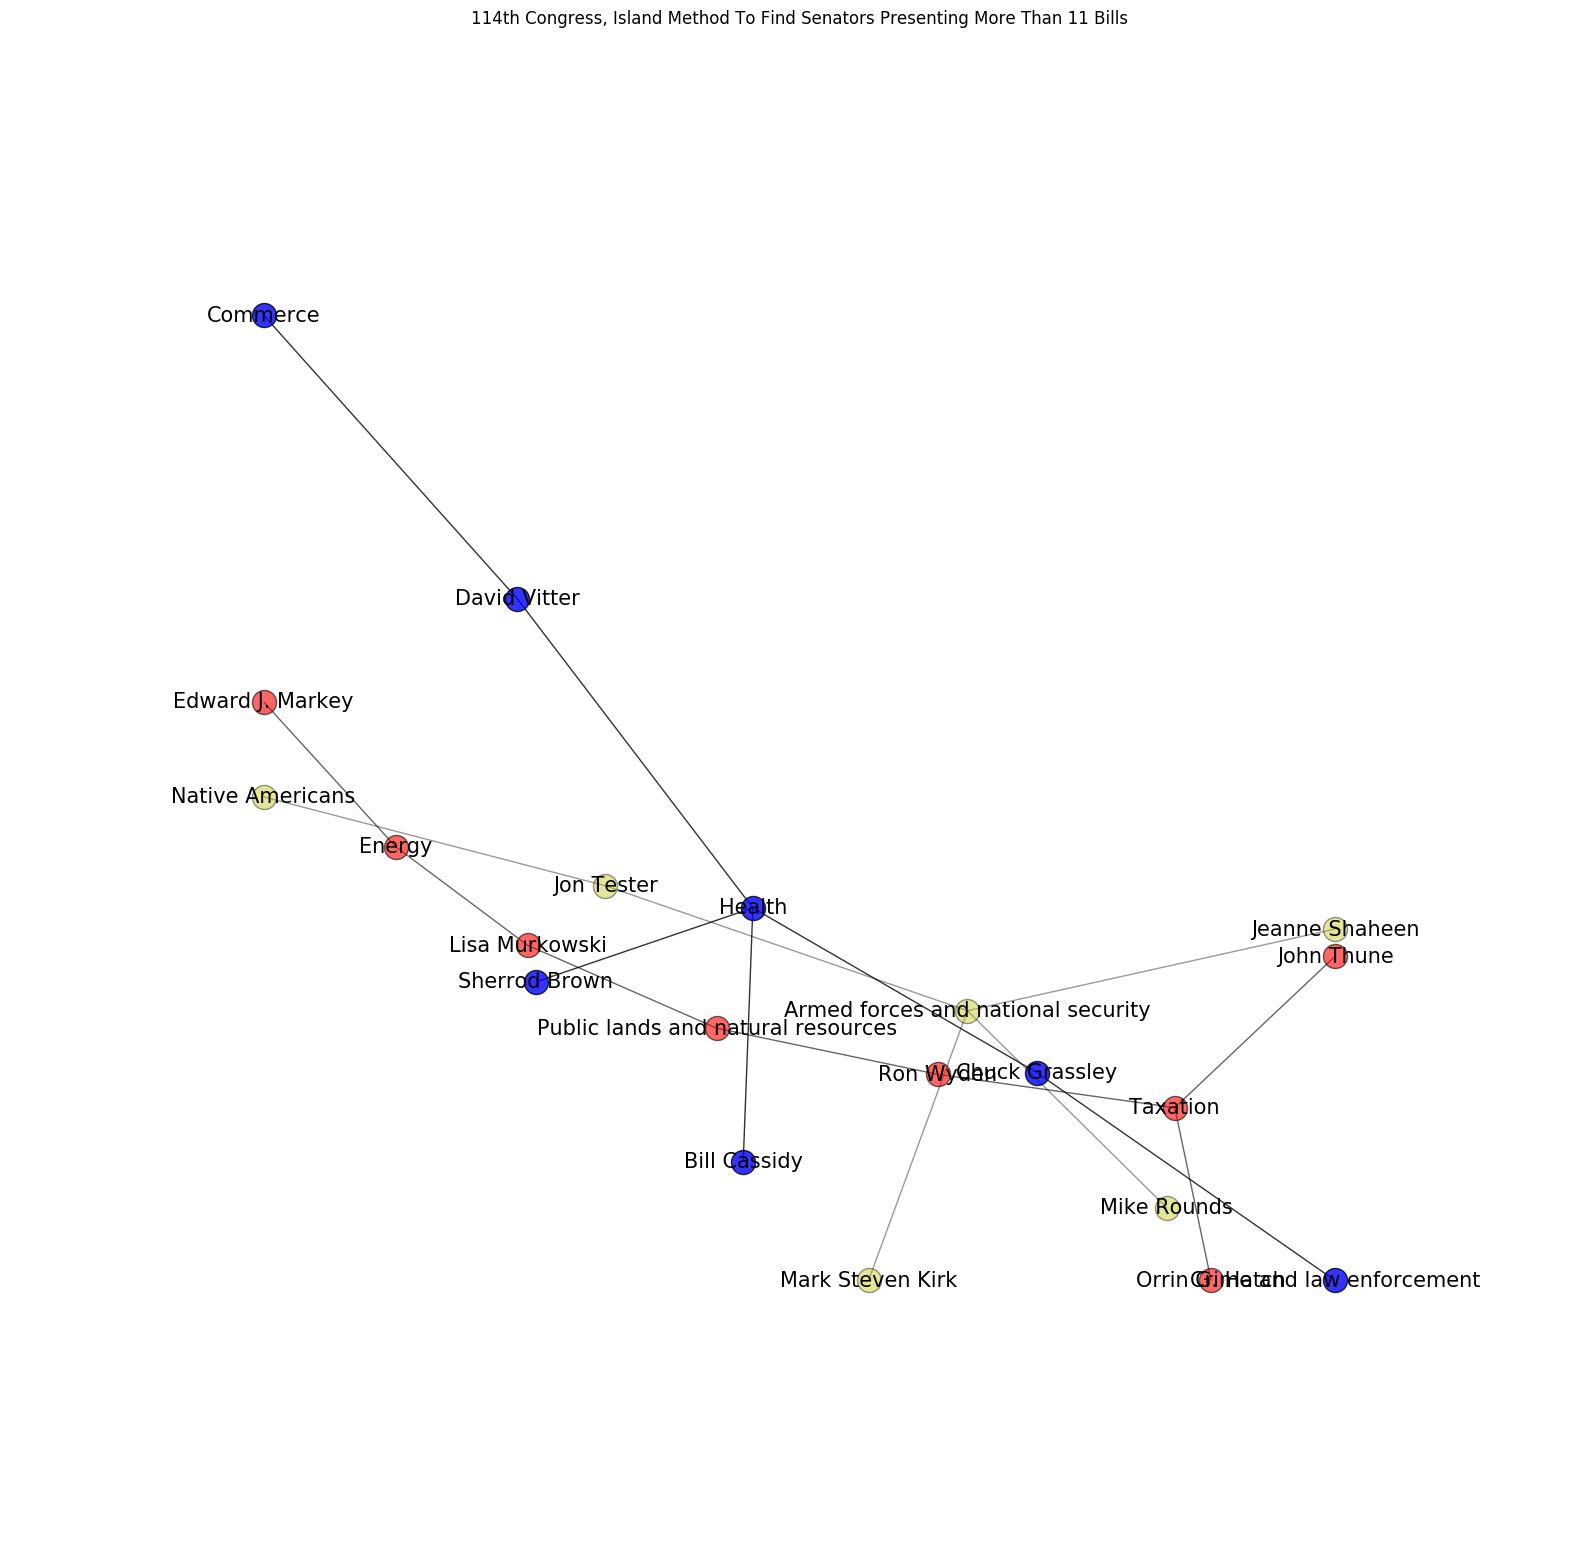

In [25]:
#Colors represent 3 different islands
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(15, 15))

for i in islands:
    if i[0] == 11:
        j = 0
        for c in nx.connected_component_subgraphs(i[1]):
            if j == 0:
                nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'b')
            if j == 1:
                nx.draw(c, with_labels=True, font_size=15, alpha=.6, node_color = 'r')
            if j == 2:
                nx.draw(c, with_labels=True, font_size=15, alpha=.4, node_color = 'y')
            j = j + 1
            
plt.title('114th Congress, Island Method To Find Senators Presenting More Than 11 Bills')
plt.show()


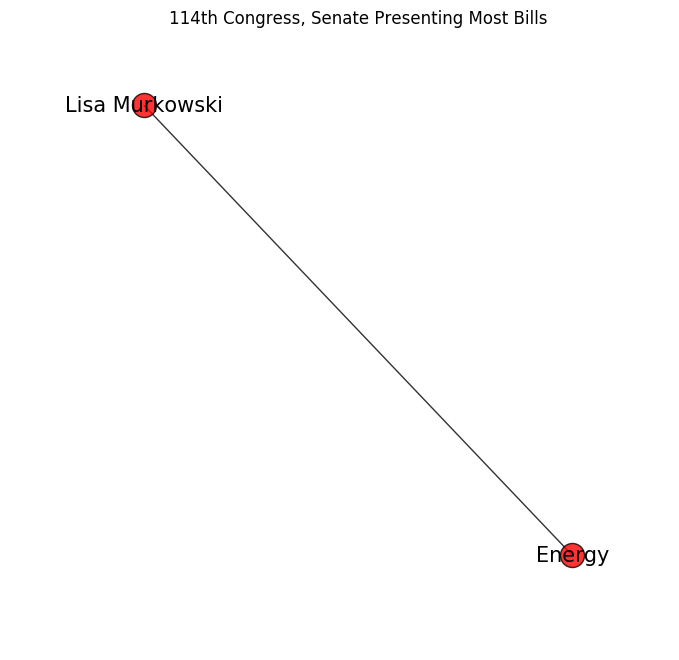

In [26]:
#Senetor presenting most bills on popular subject
%matplotlib inline
#pos = nx.erdos_renyi_graph(B)
fig = plt.figure(figsize=(6, 6))

for i in islands:
    if i[0] == 26:
        for c in nx.connected_component_subgraphs(i[1]):
            nx.draw(c, with_labels=True, font_size=15, alpha=.8, node_color = 'r')
            
plt.title('114th Congress, Senate Presenting Most Bills')
plt.show()